# Using Keras for Traffic Sign Recognition 
(by: [Nicolaj Stache](mailto:Nicolaj.Stache@hs-heilbronn.de) and [Andreas Schneider](mailto:Andreas.Schneider@hs-heilbronn.de), both: Heilbronn University, Germany)

This tutorial shows how to recognize german traffic signs with a convolutional deep neural network in TensorFlow. 

### Get Traffic Sign - Training Data

The first step is to load the traffic sign data. The database is thanks to: [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The data is stored here in a format called pickle. Hence, we have to import the pickle library to open the database. 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle


training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
trainXo, trainY = train['features'], train['labels']
testXo, testY = test['features'], test['labels']

Training and test data are now stored in the variables trainXo and testXo. The corresponding labels are in trainY and testY.

### Have a look at the data
Now, let us get an overview on what we downloaded. It is important to check if preprocessing steps on the data are necessary.

Number of train images, number of pixels:  39209
Number of test images, number of pixels:   12630 

Image data shape  = (32, 32, 3)
Number of classes = 43 

Classes: 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42} 

Values in the training images go from 0 to 255 .


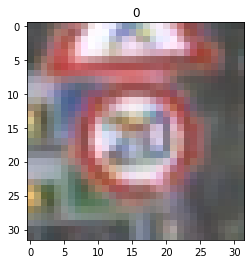

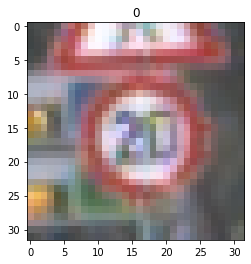

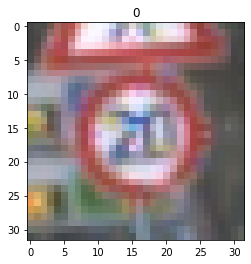

In [2]:
print('Number of train images, number of pixels: ', trainXo.shape[0])
print('Number of test images, number of pixels:  ', testXo.shape[0], '\n')

image_shape = (trainXo.shape[1:4])
print('Image data shape  =', image_shape)

classes = set(trainY)
print('Number of classes =', len(classes),'\n')
print('Classes: \n', classes, '\n')

print('Values in the training images go from', np.min(trainXo), 'to', np.max(trainXo), '.')

%matplotlib inline
for i in range(0,3):
    plt.imshow(trainXo[i])
    plt.title(trainY[i])
    plt.show()

What becomes clearer now is the following: 
- The data is not normalized (values go from 0 ... 255, some images are dark, others are bright)
- The images seem to be ordered
- We have a training dataset and a testing dataset but no validation dataset
- The labels are not one-hot-vectors

### Data normalization
The data is in the format of RGB-Images with values of 0...255 for each color channel. The images were taken under varying lighting and contrast conditions. To process data with a neural network and use it for training, it is vital to normalize the data. There are different ways of doing so - the essence of most methods is to scale data to a range of approximately 0...1 and center it around zero. Our way of doing so is shown below - we first subtract an offset (min-value) and then scale it to the range of 0...1. By subtraction of 0.5, we bring it to a symmetric interval around zero. 

However, there are by far more sophisticated methods like histogram equalization, percentile-based contrast stretching, etc. which may perform better.

In [3]:
from skimage import color, exposure

def normalize(x):
    '''scaling and shifting of data to -0.5 ... +0.5 '''
    img_max = np.max(x)
    img_min = np.min(x)
    return (x - img_min) / (img_max - img_min) - 0.5

# convert data to float
trainX = trainXo.astype(float)  
testX = testXo.astype(float)

# apply normalization to trainX and testX
print('Normalize training data: please wait ...')
for i in range(0, trainXo.shape[0]): 
    trainX[i] = normalize(trainXo[i])
    
print('Normalize test data: please wait ...')
for i in range(0, testXo.shape[0]):
    testX[i] = normalize(testXo[i])

print('Normalization finished!')

Normalize training data: please wait ...
Normalize test data: please wait ...
Normalization finished!


### Randomly distribute data + create validation dataset 
An ordered training database is disturbing because we will not process it as a whole in the training phase of the neural network. Data is rather split into batches of defined size (e.g. 128 entries) and we consider each batch to be representative for the whole dataset. Hence, we need to ensure that the data is randomly shuffled.

A very comfortable way of shuffeling data and splitting datasets is the method `StratifiedShuffleSplit` of the Python library scikit learn (=`sklearn`). It creates randomized indices which are assigned to the new datasets. 

Perhaps you might notice that the test dataset is still ordered - which is ok, since it is always considered as a whole and not used for parameter updates. 

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

# create shuffle-split object
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Create shuffled indices
train_idx, val_idx = next(ss.split(trainX, trainY))

# Assign back to data variables again
valX, valY = trainX[val_idx], trainY[val_idx]
trainX, trainY = trainX[train_idx], trainY[train_idx]

### Visualize results

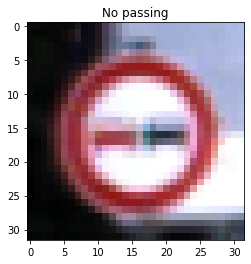

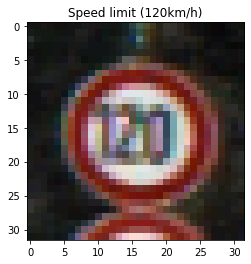

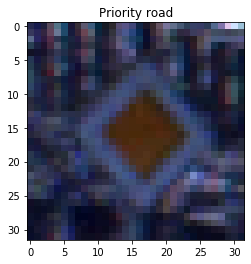

In [5]:
from numpy import genfromtxt

def decodeYtoCorrespondingString(y):
    '''Convert numeric label Y into string'''
    signnames = genfromtxt('signnames.csv', delimiter=',', dtype=str, skip_header = 1)
    string = signnames[y][1]    
    return string  

# Output
%matplotlib inline
for i in range(0,3):
    plt.imshow((trainX[i]+0.5))
    plt.title(decodeYtoCorrespondingString(trainY[i]))
    plt.show()

### Convert labels to one-hot encoded vectors
Here we make use of the LabelBinarizer of scikit-learn. It is a tool which is exactly designed for our task. You can read more about it in the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html).

In [6]:
from tensorflow.keras.utils import to_categorical

print('This is how the label looks before: ', trainY[0])

trainY = to_categorical(trainY)
testY  = to_categorical(testY)
valY   = to_categorical(valY)

print('This is how the label looks before: ', trainY[0])

This is how the label looks before:  9
This is how the label looks before:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Network design

We now want to design and train a deep convolutional network to recognize traffic signs.

The input of the network is the RGB-image of 32x32 pixels and 3 color channels. The output of the network is a vector with 43 entries, as we have 43 classes. What happens in between is shown in the illustration below:

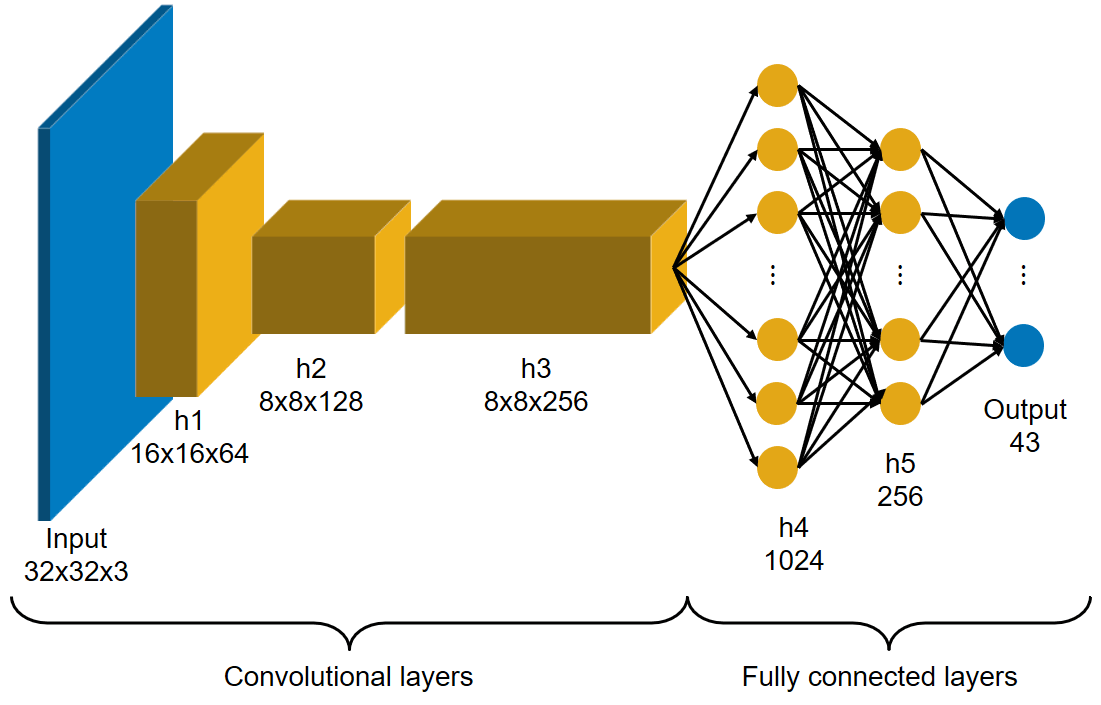

### Definition of the network structure
Here, we define the layers of the network, starting with the first real layer, which is the hidden layer `h1`. According to the network diagram, it is a convolutional layer which has 64 filters. Due to the shrinked size of its output width and height (16x16 instead of 32x32), we can infer that the stride is 2. This means that the filter kernel is shifted every 2 pixels and thus reduces the output in width and height. The filter kernel size is defined to 3 for all filter kernels used here. The other convolutional layers are built up accordingly. 

To feed the data of `h3` to the fully connected layer, it needs to be flattened by the reshape command. In fact, it is now a 8x8x256-input vector to a fully connected network (or dense network). The dense network is built like shown in the figure. A  dropout of 10% is configured to make the network generalize better from training data. 

Finally, we have the last layer with 43 output units, corresponding to our one-hot-encoded labels. The output is named logits since it is intended to be mapped to ouptut pobabilites by the softmax function.

> __TODO: Fill-in the missing figures below (= replace "`None`"), be careful to match the resulting size!__

In [7]:
from tensorflow.keras import backend as K
K.backend()

'tensorflow'

In [8]:
K.image_data_format()

'channels_last'

In [9]:
trainX.shape, trainY.shape

((31367, 32, 32, 3), (31367, 43))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, Flatten
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam, SGD

In [11]:
initalizer = TruncatedNormal(stddev=0.1)

def build_network():    
    K.clear_session()
    # Building the model
    model = Sequential()
    model.add(Conv2D(64, input_shape=(32, 32, 3),  activation='relu', kernel_size=3, strides=2, 
                     padding="same", kernel_initializer=initalizer, bias_initializer=initalizer))
    model.add(Conv2D(128,activation='relu', kernel_size=3, strides=2, 
                     padding="same", kernel_initializer=initalizer, bias_initializer=initalizer))
    model.add(Conv2D(256,activation='relu', kernel_size=3, strides=1, 
                     padding="same", kernel_initializer=initalizer, bias_initializer=initalizer))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_initializer=initalizer, bias_initializer=initalizer))
    model.add(Dropout(.1))
    model.add(Dense(256,  activation='relu', kernel_initializer=initalizer, bias_initializer=initalizer))
    model.add(Dropout(.1))
    model.add(Dense(trainY.shape[1], activation="softmax")) 

    # Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return model

In [12]:
print(trainX.shape)
model = build_network()
#model.load_weights("weights_keras_trafficsignrecognition.h5")
model.summary()
model.fit(trainX, trainY, epochs=1, batch_size=512, verbose=1)
model.save_weights("weights_keras_trafficsignrecognition.h5")

(31367, 32, 32, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              16778240  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2

## Perform predictions on the trained model

Prediction: Yield


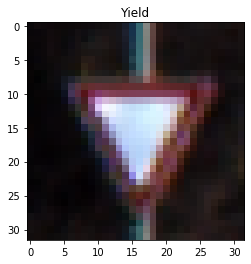

In [13]:
from random import randint
i =randint(0, testX.shape[0])
img = np.expand_dims(testX[i], axis=0)
prediction = model.predict_classes(img)
print("Prediction:", decodeYtoCorrespondingString(prediction[0]))

plt.imshow((testX[i]+0.5))
plt.title(decodeYtoCorrespondingString(np.argmax(testY[i])))
plt.show()

### Apply the neural network to your own data

Now, we want to classify our own images of traffic signs, e.g taken with our smartphone. For this, we have to follow these steps:
1. Change camera settings of your phone to the __lowest possible resolution__ - it could be indicated by 0.3M (640x480 pixels). If your mobile phone supports quadratic images, choose this option in the lowest resolution.
2. Take photos of traffic signs. Note: the images will be cropped to a quadratic shape and shrinked to 32x32 pixels. The  sign shall thus be __roughly centered in the image__ and be of reasonable size.
3. The easiest way to get images into this notebook is to send them by email attachment to __training_a9c1@sendtodropbox.com__ (plese note: it seems to only work if the email-address is completely in lower-case). The files you uploaded this way are all shared among the participants of the semiar! As an alternative, you could also include your own dropbox-directory by updating "`downloadLink`" in the code below. Take care of the ending of the link which needs to be `?dl=1` for downloading all files as a zip-file. A second alternative would be to use the upload function of jupyter notebook to the images folder on our server. Feel free to choose your favorite way.



> __TODO: Try to figure out the limitations of the neural network:__
This TODO needs to be done in groups - otherwise, we would have too many images in our download folder. Just ask the persons sitting to your left and right...!
> 1. Choose a traffic-sign which is correctly classified under normal conditions
> 2. Take photos of this traffic sign and vary the conditions (e.g. light, rotation, partial occlusion) slightly.

> By this, try to figure out, when the classification starts to fail. Present your group result to the plenum. 



### Download Image & Unzip it

In [14]:
import urllib.request
import os
import shutil
import zipfile

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f


downloadLink = 'https://www.dropbox.com/sh/kc90cgke1u7c9z9/AABePPzyzuzUd0FpNtYy_vgCa?dl=1'
downloadPath = './downloads/pictures.zip'

with urllib.request.urlopen(downloadLink) as response, open(downloadPath, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)    

#delete existing files in folder before extracting
fileList = listdir_nohidden("./mytestpictures")
for fileName in fileList:
     os.remove("./mytestpictures/" + fileName)

#unzip 
with zipfile.ZipFile(downloadPath,"r") as zip_ref:
    zip_ref.extractall("./mytestpictures")

print('Download completed!')

Download completed!


### Read data from folder & Convert it & Preview it

In the block below, we just crop, scale and normalize the images and finally show them on the screen.

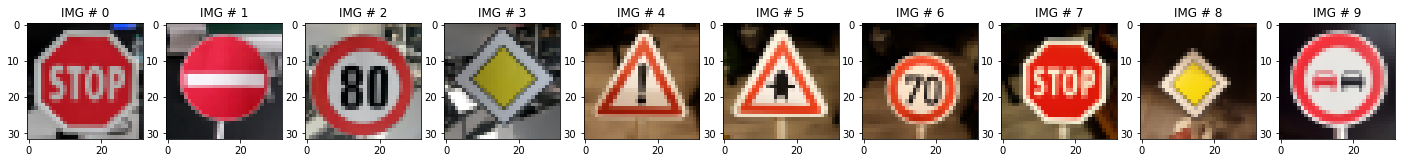

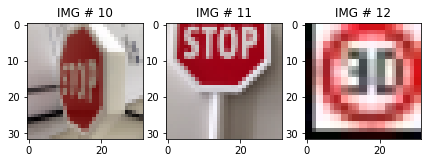

In [15]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

test_example_images = []
path = './mytestpictures/'

for image in listdir_nohidden(path):
    # read image
    newImage = cv2.imread(path + image)
    
    # crop image to 1:1 aspect ratio
    xysize = np.min(newImage.shape[0:2])
    starty = (newImage.shape[0]-xysize)//2
    startx = (newImage.shape[1]-xysize)//2
    newImage = newImage[starty:starty+xysize, startx:startx+xysize, :]
    
    # resize to 32x32 pixels, apply normalization
    newImage = cv2.resize(newImage,(32,32),fx=1, fy=1, interpolation = cv2.INTER_AREA)    
    newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB) 
    newImage = normalize(newImage)
    
    test_example_images.append(newImage)
              
# Display shape of test images and pre-process
test_example_images = np.array(test_example_images)


# Count Images in Folder
amountOfTestPictures = test_example_images.shape[0]

# Show Images
def showExampleImages():
    for index in range(amountOfTestPictures):  
        if (index % 10 == 0):
            fig = plt.figure(figsize=(32,32))
        subplot = fig.add_subplot(1,amountOfTestPictures,index+1)
        subplot = subplot.imshow(test_example_images[index]+0.5)
        subplot = plt.title("IMG # "+str(index))
    plt.show()

showExampleImages()

### Predict with own images

Prediction  0 : Stop
Prediction  1 : No entry
Prediction  2 : Speed limit (20km/h)
Prediction  3 : Priority road
Prediction  4 : General caution
Prediction  5 : Right-of-way at the next intersection
Prediction  6 : Speed limit (50km/h)
Prediction  7 : Stop
Prediction  8 : Priority road
Prediction  9 : No passing
Prediction  10 : Stop
Prediction  11 : General caution
Prediction  12 : No passing


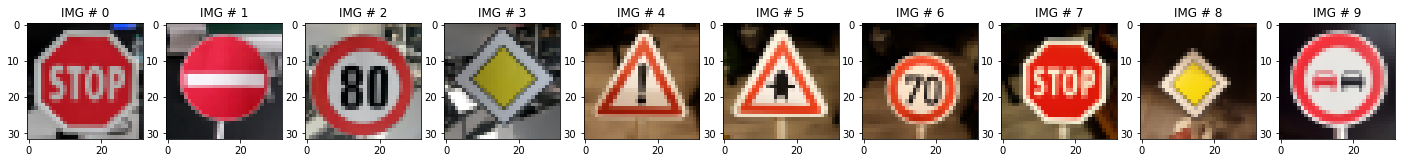

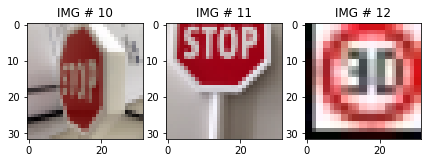

In [16]:
prediction = model.predict_classes(test_example_images)
for i in range(0, test_example_images.shape[0]):
    print("Prediction ",i,":", decodeYtoCorrespondingString(prediction[i]))
showExampleImages()

### The End
I hope, this tutorial helped you to get a better understanding of convolutional neural networks. 
There is just one code-block below (also for debugging purposes), which shows examples from the test database for each class.

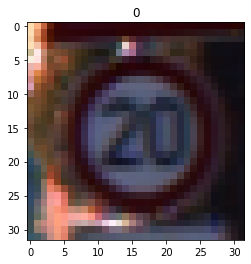

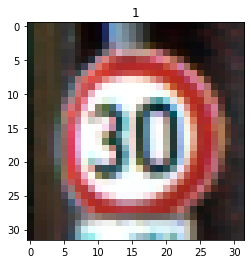

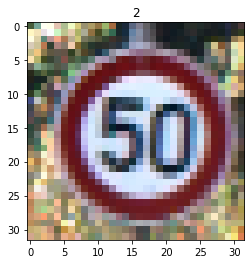

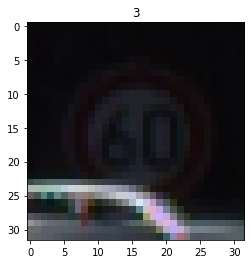

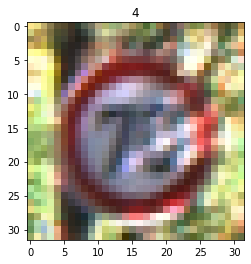

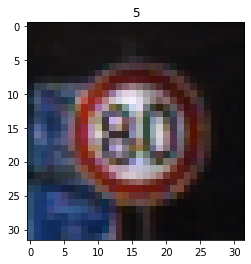

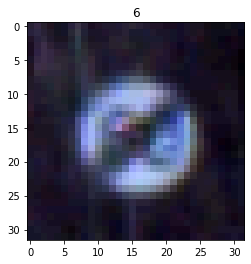

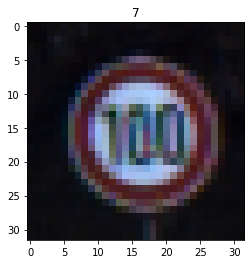

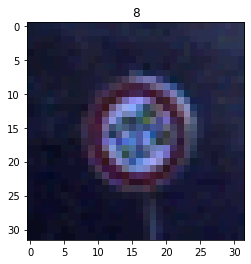

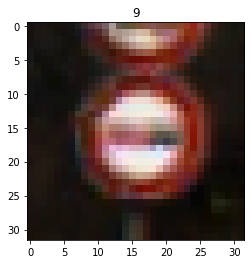

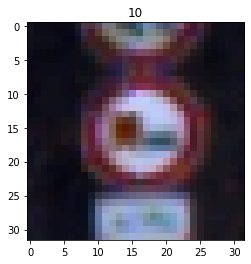

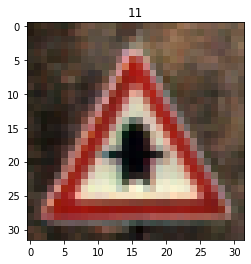

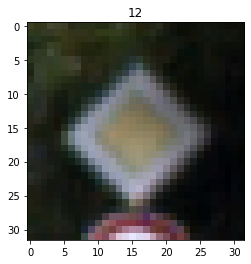

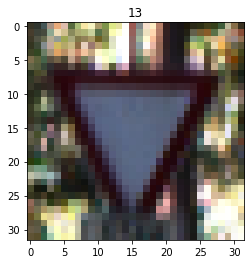

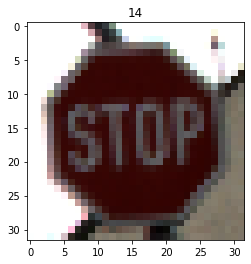

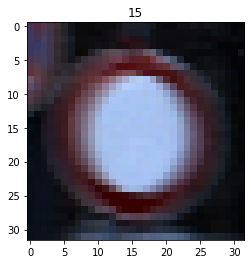

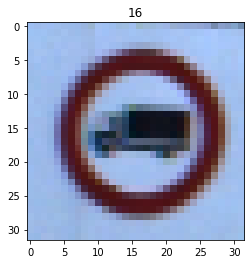

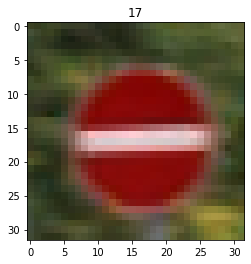

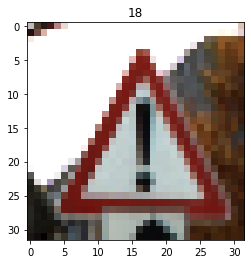

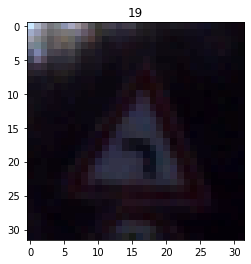

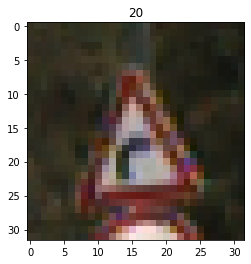

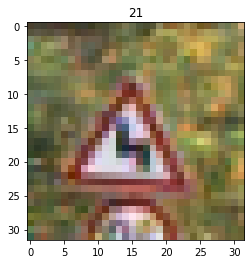

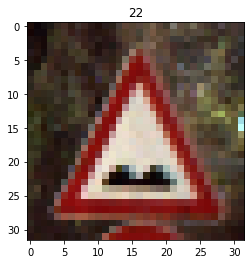

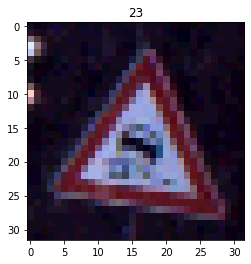

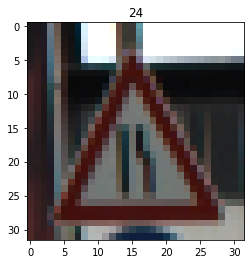

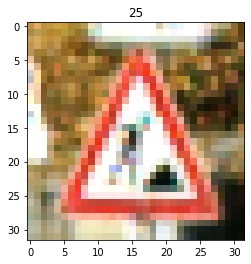

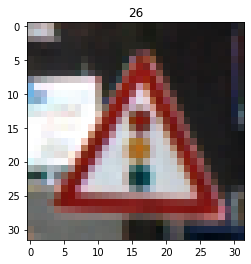

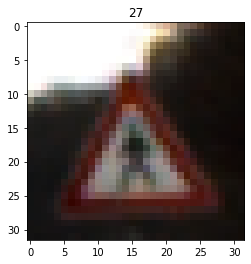

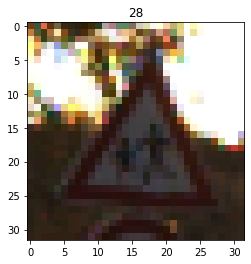

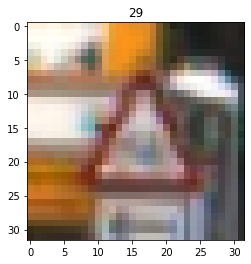

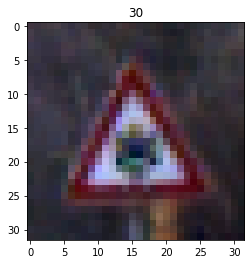

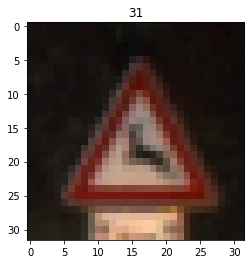

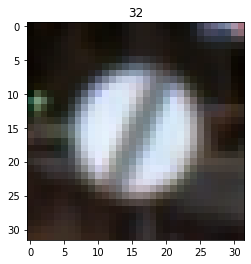

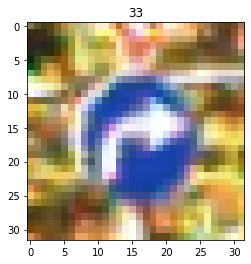

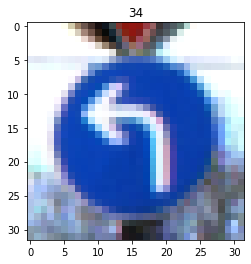

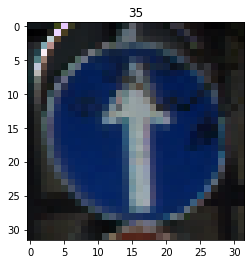

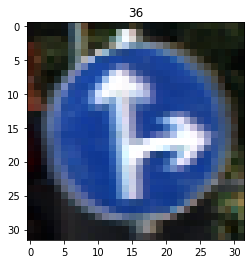

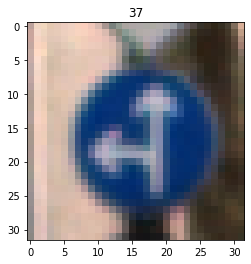

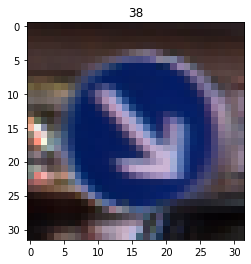

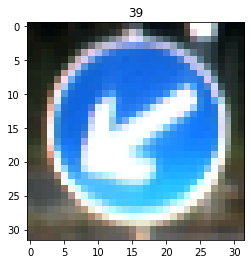

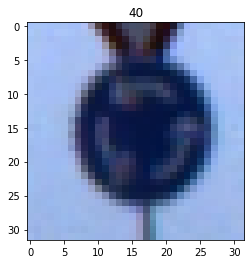

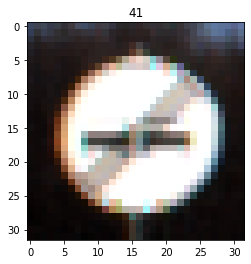

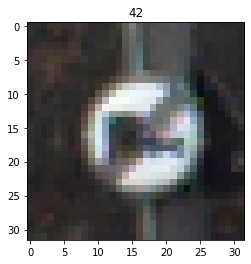

In [17]:
## show examples of all classes

def showimage(label):
    '''finds image representation in the test database'''
    index = [i for i in range(len(testY)) if np.argmax(testY[i]) == label]
    plt.imshow(testX[index[0]]+0.5)
    plt.title(np.argmax(testY[index[0]]))
    plt.show()
    
for i in range(0,43):
    showimage(i)